### Useful Classes and functions

In [54]:
import random

class Sentiment:
    negative = "negative"
    positive = "positive"

class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()

    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.negative

        if self.score > 3:
            return Sentiment.positive

class ReviewCustom:
    def __init__(self, reviews):
        self.reviews = reviews

    def distribute_even(self):
        neg_reviews = list(filter(lambda x: x.sentiment == Sentiment.negative, self.reviews))
        pos_reviews = list(filter(lambda x: x.sentiment == Sentiment.positive, self.reviews))
        pos_new = pos_reviews[:len(neg_reviews)]
        self.reviews = neg_reviews + pos_new
        random.shuffle(self.reviews)

    def get_text(self):
        return [x.text for x in self.reviews]

    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]

### Loading Amazon Instant Video JSON review data, source: http://jmcauley.ucsd.edu/data/amazon/

In [55]:
import json

file = 'json/Amazon_Instant_Video_5.json'

reviews = []

with open(file) as f:
    for line in f:
        review = json.loads(line)
        reviews.append(Review(review['reviewText'], review['overall']))

print(reviews[0].text)

I had big expectations because I love English TV, in particular Investigative and detective stuff but this guy is really boring. It didn't appeal to me at all.


### Data Preparation

In [56]:
from sklearn.model_selection import train_test_split

#train-test split
train, test = train_test_split(reviews, test_size = 0.2, random_state=1)
train_new = ReviewCustom(train)
test_new = ReviewCustom(test)
test_new.distribute_even()

In [57]:
train_new.distribute_even()
X_train = train_new.get_text()
Y_train = train_new.get_sentiment()

X_test = test_new.get_text()
Y_test = test_new.get_sentiment()
Y_train.count(Sentiment.positive)

2886

### Feature extraction using TF-IDF vectorizer

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

#TF-IDF considers the weights of each word that appears in the document
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
X_train_vecs = vectorizer.fit_transform(X_train)
X_test_vecs = vectorizer.transform(X_test)

### Classifiers
### SVM

In [59]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn import metrics

lsvm_classifier = svm.SVC(kernel='rbf', C=8, random_state=42).fit(X_train_vecs, Y_train)

print("True Sample Sentiment:", Y_test[0])
print("Sample Prediction:", lsvm_classifier.predict(X_test_vecs[0]))
print("Mean Accuracy:", lsvm_classifier.score(X_test_vecs, Y_test))

True Sample Sentiment: positive
Sample Prediction: ['positive']
Mean Accuracy: 0.8695955369595537


### Decision Tree

In [60]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=0)
dt_classifier.fit(X_train_vecs, Y_train)

print("True Sample Sentiment:", Y_test[0])
print("Sample Prediction:", dt_classifier.predict(X_test_vecs[0]))
print("Mean Accuracy:", dt_classifier.score(X_test_vecs, Y_test))

True Sample Sentiment: positive
Sample Prediction: ['negative']
Mean Accuracy: 0.698744769874477


### Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression

lg_classifier = LogisticRegression(random_state=0, max_iter=500)
lg_classifier.fit(X_train_vecs, Y_train)

print("True Sample Sentiment:", Y_test[0])
print("Sample Prediction:", lg_classifier.predict(X_test_vecs[0]))
print("Mean Accuracy:", lg_classifier.score(X_test_vecs, Y_test))

True Sample Sentiment: positive
Sample Prediction: ['positive']
Mean Accuracy: 0.8688981868898187


### Evaluating Models using F1 score

In [62]:
from sklearn.metrics import f1_score

f1_lsvm = f1_score(Y_test, lsvm_classifier.predict(X_test_vecs), average=None, labels=[Sentiment.positive, Sentiment.negative])
f1_dt = f1_score(Y_test, dt_classifier.predict(X_test_vecs), average=None, labels=[Sentiment.positive, Sentiment.negative])
f1_lg = f1_score(Y_test, lg_classifier.predict(X_test_vecs), average=None, labels=[Sentiment.positive, Sentiment.negative])

print(f1_lsvm, f1_dt, f1_lg)

[0.8707671  0.86840253] [0.69832402 0.69916435] [0.86962552 0.86816269]


### Confusion Matrix

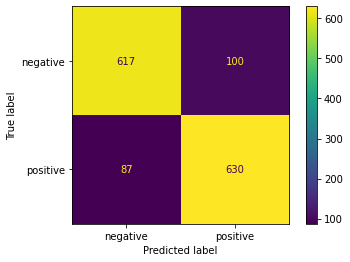

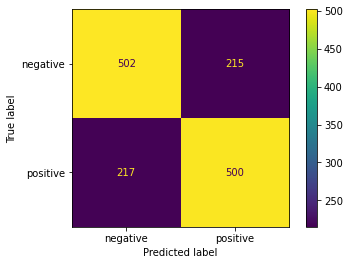

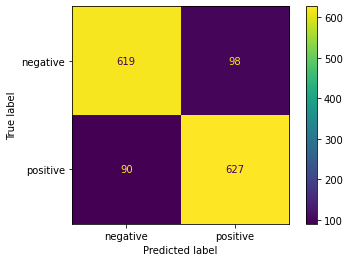

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(lsvm_classifier, X_test_vecs, Y_test)  
plot_confusion_matrix(dt_classifier, X_test_vecs, Y_test)  
plot_confusion_matrix(lg_classifier, X_test_vecs, Y_test)  
plt.show()


### Model Tuning (Grid Search)

In [64]:
# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':(1,4,8,12)}
# svc = svm.SVC()
# clf = GridSearchCV(svc, parameters)
# clf.fit(X_train_vecs, Y_train)
# print("Best parameters for SVM :", clf.best_params_)

### Performance Improvement using K-Fold Cross-Validation and Pipelining

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.pipeline import Pipeline

#using full data for k-fold cross validation 
full_data = ReviewCustom(reviews)
full_data.distribute_even()
X_full = full_data.get_text()
Y_full = full_data.get_sentiment()

# #TF-IDF considers the weights of each word that appears in the document
# vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')

# #TF-IDF on full data 
# X_full_vecs = vectorizer.fit_transform(X_full)

# lsvm_classifier = svm.SVC(kernel='rbf', C=8, random_state=42)

pipeline = Pipeline([('vect', TfidfVectorizer()), ('svm', svm.SVC(kernel='rbf', C=8, random_state=42))])
cross_val = cross_val_score(pipeline, X_full, Y_full, cv=5, scoring='f1_weighted')

print("Cross-validated F1 scores :", cross_val)
print("Mean Cross-validated F1 score :", cross_val.mean())

Cross-validated F1 scores : [0.90291187 0.90768609 0.89797572 0.90770298 0.90839668]
Mean Cross-validated F1 score : 0.9049346694138221
